**Шевченко Глеб Олегович 214-322**

# Задание 1 Метод k-ближайших соседей (kNN) для задачи классификации изображений

Цель: написать классификатор kNN и использовать его на базе CIFAR-10.

Скачать базу изображений CIFAR-10 для задания можно по ссылке https://www.cs.toronto.edu/~kriz/cifar.html.

Этапы выполнения:

1. Обучить классификатор — выгрузить все данные в память;
2. Проверить классификатор — сравнить все тестовые изображения с изображениями из обучения и присвоить классы от k ближайших соседей;
3. Провести перекрестную проверку гиперпараметра k.

Ниже созданы ячейки для кода с комментариями, в которых указано, что необходимо сделать.

In [6]:
# coding: utf8 Для кодировки и отображения графиков в этом же "блокноте".

from __future__ import unicode_literals

import os
import random
from builtins import object, range

import matplotlib.pyplot as plt
import numpy as np
import math
from collections import Counter
from past.builtins import xrange
# from six.moves import cPickle as pickle
import pickle

%matplotlib inline


ROOT = "/cifar-10-python/cifar-10-batches-py"  # Путь до папки, где распакован CIFAR10

In [2]:
# Функции для загрузки данных CIFAR10 в память

def load_CIFAR_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='latin1')
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [7]:
try:
    del x_train, y_train
    del x_test, y_test
    print('Удаляем ранее загруженные данные.')
except:
    pass

x_train, y_train, x_test, y_test = load_CIFAR10(ROOT)  # Загружаем данные

# Выводим информацию о размерностях для проверки работоспособности.
print('Training data shape: ', x_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [8]:
# Берем выборку изображений, для сокращения времени исполнения кода.
num_training = 5000
mask = list(range(num_training))
x_train = x_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
x_test = x_test[mask]
y_test = y_test[mask]

# Преобразуем изображения в строки
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
print(x_train.shape, x_test.shape)

(5000, 3072) (500, 3072)


In [9]:
class KNearestNeighbor(object):
    #Классификатор kNN с L2 расстоянием
    def __init__(self):
        pass

    def train(self, X, y):
#         Обучение классификатора это просто помещение данных в память.
#     Ввод:
#     - X: Массив numpy размерности (N, D) содержащий данные для обучения;
#     - y: Массив numpy размерности (N,) содержащий названия классов для обучения.
        self.X_train = X
        self.y_train = y
    
    def predict(self, X, k=1):
#         Предсказание классов для тестовой выборки, используя классификатор.
#     Ввод:
#     - X: Массив numpy размерности (N, D) содержащий данные для тестирования;
#     - k: количество соседей.
#     Вывод:
#     - y: Массив numpy размерности (N,) содержащий названия классов для тестирования.
        dists = self.compute_distances(X)
        return self.predict_labels(dists, k=k)

    def compute_distances(self, X):
#     Теперь необходимо рассчитать расстояния между изображениями обучающей и тестовой выборок.
#     Должна получится матрица расстояний размерностью (Nобуч x Nтест),
#     где каждый элемент это расстояние между изображениями.
#     Ввод:
#     - X: Массив numpy размерности (N, D) содержащий данные для тестирования;
#     Вывод:
#     - dists: Массив numpy размерности (num_test, num_train), где dists[i, j]
#     евклидовы расстояния между i-ой тестовой точкой и j-ой обучающей.
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        # TODO:
        # Вычислить l2 расстояние (евклидово расстояние)
        # между the i-ой тестовой точкой и j-ой обучающей,
        # и созранить значение в dists[i, j].
        # В Python это можно сделать с двумя, циклами, с одним и без циклов.
        # Для уменьшения числа циклов необходимо использовать векторизацию.  
        for i in range(num_test):
            for j in range(num_train):
                dists[i, j] = np.sqrt(np.sum((X[i] - self.X_train[j])**2))
        return dists

    def predict_labels(self, dists, k=1):
#         Имея матрицу расстояний между тестовыми точками и обучающими,
#     нужно предсказать класс для каждой тестовой точки.
#     Ввод:
#     - dists: Массив numpy размерности (num_test, num_train), где dists[i, j]
#       евклидовы расстояния между i-ой тестовой точкой и j-ой обучающей.
#     Вывод:
#     - y: Массив numpy размерности (num_test,), содержащий предсказанные классы для тестовой выборки,
#     где y[i] это предсказанный класс для тестовой точки X[i].
      # TODO:
      # Используя матрицу расстояний, найдите k ближайших соседей к i-й тестовой точке,
      #  и с помощью self.y_train оопределите классы этих соседей.
      #  Храните эти классы в closest_y.
      # Подсказка: Посмотрите numpy.argsort.
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in range(num_test):
            closest_y = []
            closest_y = self.y_train[np.argsort(dists[i])][:k]
            closest_y = closest_y.astype(int)
            y_pred[i] = np.bincount(closest_y).argmax()
        return y_pred

In [10]:
classifier = KNearestNeighbor()
classifier.train(x_train, y_train)

In [11]:
dists = classifier.compute_distances(x_test)
# Для случая k = 1.
y_test_pred = classifier.predict_labels(dists, k=5)

num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Правильно определено %d из %d. Точность: %f' % (num_correct, num_test, accuracy))

Правильно определено 139 из 500. Точность: 0.278000


### Перекрестная проверка

Теперь необходимо выбрать лучшее значение этого гиперпараметра при помощи перекрестной проверки.
Разбейте базу на 5 подвыборок.
И рассчитайте точность для k 1, 3, 5, 8, 10, 12, 15, 20, 50, 100.

In [12]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

x_train_folds = []
y_train_folds = []

X_train_folds = np.array_split(x_train, num_folds)
y_train_folds = np.array_split(y_train, num_folds)

k_to_accuracies={}
        
for k in k_choices:
    for fold in range(num_folds): 
        #Создание данных проверки и временных обучающих данных
        validation_X_test = X_train_folds[fold]
        validation_y_test = y_train_folds[fold]
        temp_X_train = np.concatenate(X_train_folds[:fold] + X_train_folds[fold + 1:])
        temp_y_train = np.concatenate(y_train_folds[:fold] + y_train_folds[fold + 1:])
        #Инициализация класса
        test_classifier = KNearestNeighbor()
        test_classifier.train( temp_X_train, temp_y_train )
        #Расстояние
        temp_dists = test_classifier.compute_distances(validation_X_test)
        temp_y_test_pred = test_classifier.predict_labels(temp_dists, k=k)
        #Точность
        num_correct = np.sum(temp_y_test_pred == validation_y_test)
        num_test = validation_X_test.shape[0]
        accuracy = float(num_correct) / num_test
        print("k =",k,"Fold =",fold,"Accuracy =",accuracy)
        k_to_accuracies[k] = k_to_accuracies.get(k,[]) + [accuracy]

# Вывод точностей
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, точность = %f' % (k, accuracy))

k = 1 Fold = 0 Accuracy = 0.263
k = 1 Fold = 1 Accuracy = 0.257
k = 1 Fold = 2 Accuracy = 0.264
k = 1 Fold = 3 Accuracy = 0.278
k = 1 Fold = 4 Accuracy = 0.266
k = 3 Fold = 0 Accuracy = 0.239
k = 3 Fold = 1 Accuracy = 0.249
k = 3 Fold = 2 Accuracy = 0.24
k = 3 Fold = 3 Accuracy = 0.266
k = 3 Fold = 4 Accuracy = 0.254
k = 5 Fold = 0 Accuracy = 0.248
k = 5 Fold = 1 Accuracy = 0.266
k = 5 Fold = 2 Accuracy = 0.28
k = 5 Fold = 3 Accuracy = 0.292
k = 5 Fold = 4 Accuracy = 0.28
k = 8 Fold = 0 Accuracy = 0.262
k = 8 Fold = 1 Accuracy = 0.282
k = 8 Fold = 2 Accuracy = 0.273
k = 8 Fold = 3 Accuracy = 0.29
k = 8 Fold = 4 Accuracy = 0.273
k = 10 Fold = 0 Accuracy = 0.265
k = 10 Fold = 1 Accuracy = 0.296
k = 10 Fold = 2 Accuracy = 0.276
k = 10 Fold = 3 Accuracy = 0.284
k = 10 Fold = 4 Accuracy = 0.28
k = 12 Fold = 0 Accuracy = 0.26
k = 12 Fold = 1 Accuracy = 0.295
k = 12 Fold = 2 Accuracy = 0.279
k = 12 Fold = 3 Accuracy = 0.283
k = 12 Fold = 4 Accuracy = 0.28
k = 15 Fold = 0 Accuracy = 0.252
k = 

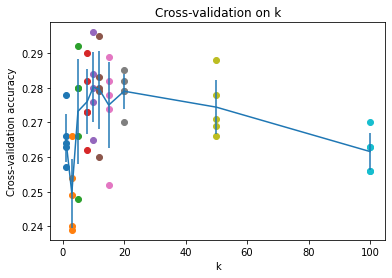

[0.2656 0.2496 0.2732 0.276  0.2802 0.2794 0.275  0.279  0.2744 0.2616]


In [13]:
# График с линией тренда
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()
print(accuracies_mean)

In [14]:
# Выберите k с наибольшей точностью.   
# Переобучите классификатор на всех обучающих данных и проверьте на тестовой выборке.
# Вы должны получить точность около 28%.

best_k =  10

classifier = KNearestNeighbor()
classifier.train(x_train, y_train)
y_test_pred = classifier.predict(x_test, k=best_k)

# Рассчет и вывод точности
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Правильно определено %d из %d. Точность: %f' % (num_correct, num_test, accuracy))

Правильно определено 141 из 1000. Точность: 0.141000


In [15]:
print(y_test_pred)
print(y_test)

[4. 8. 8. 8. 4. 2. 6. 4. 2. 8. 0. 8. 4. 6. 8. 8. 5. 3. 8. 2. 2. 0. 0. 6.
 2. 4. 4. 7. 4. 2. 4. 2. 4. 3. 8. 6. 2. 8. 2. 4. 8. 6. 2. 4. 0. 8. 5. 0.
 4. 2. 8. 8. 6. 2. 8. 8. 5. 6. 0. 2. 2. 6. 6. 0. 4. 2. 8. 0. 3. 9. 2. 4.
 8. 8. 0. 2. 8. 3. 6. 8. 8. 6. 2. 0. 2. 8. 2. 8. 8. 8. 0. 2. 0. 2. 2. 2.
 4. 0. 0. 4. 4. 4. 3. 3. 4. 8. 4. 6. 5. 5. 4. 0. 6. 2. 4. 4. 0. 4. 4. 4.
 8. 4. 2. 2. 8. 4. 8. 6. 4. 2. 2. 8. 8. 6. 2. 2. 9. 0. 2. 8. 2. 8. 0. 2.
 8. 0. 6. 2. 5. 5. 0. 3. 0. 8. 4. 4. 0. 8. 5. 4. 0. 2. 2. 4. 8. 0. 8. 2.
 5. 0. 8. 7. 2. 8. 4. 9. 0. 4. 4. 0. 8. 3. 2. 4. 2. 0. 6. 6. 1. 8. 2. 4.
 2. 2. 4. 4. 8. 0. 4. 0. 2. 7. 8. 4. 8. 4. 0. 2. 2. 0. 4. 8. 0. 7. 8. 0.
 0. 9. 0. 4. 6. 6. 0. 2. 2. 2. 4. 2. 3. 4. 3. 1. 2. 4. 0. 2. 6. 9. 0. 0.
 0. 0. 8. 0. 2. 4. 6. 0. 4. 3. 2. 3. 4. 6. 2. 8. 2. 0. 8. 4. 5. 8. 4. 2.
 2. 8. 8. 4. 0. 0. 2. 6. 6. 3. 8. 2. 8. 2. 6. 6. 8. 4. 2. 8. 0. 4. 5. 8.
 2. 8. 2. 4. 2. 8. 3. 4. 2. 0. 8. 2. 2. 6. 4. 2. 4. 8. 8. 2. 1. 4. 8. 4.
 0. 0. 2. 0. 2. 4. 6. 4. 5. 6. 6. 4. 2. 8. 0. 2. 2.

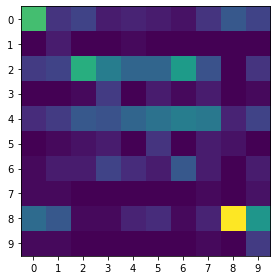

In [19]:
# Построить матрицу ошибок (confusion matrix) для 10 классов для лучшей модели,
# чтобы оценить в каких классах модель допускает больше всего ошибок.

# ***Начало вашего кода***
matrix = np.zeros((10,10))
for i in range(len(y_test_pred)):
    matrix[int(y_test_pred[i])][y_test[i]] += 1

pass

# ***Конец вашего кода***

confusion_matrix =  matrix # присвоить матрицу ошибок переменной confusion_matrix

fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix)

ax.set_xticks(np.arange(10), labels=[x for x in range(10)])  # Массив в labels можно с индексов заменить на имена классов
ax.set_yticks(np.arange(10), labels=[x for x in range(10)])  # Массив в labels можно с индексов заменить на имена классов

# for i in range(10):
#     for j in range(10):
#         text = ax.text(j, i, confusion_matrix[i, j], ha="center", va="center", color="w")

fig.tight_layout()
plt.show()

## Анализ данных

Проанализировать данные и сделать выводы о возможных проблемах.

Выводы:
1. Лучше всего программа определяет классы 0, 2, 8.
2. Точность у классификатора низкая и перекрёстная проверка проходит долго.
3. Класс 4 может путаться с классами 5, 6, 7.